In [1]:
# Run Functional connectivity on LMB data
# import
from nilearn import datasets
from nilearn import surface
from nilearn import plotting
from nilearn import image
import numpy as np
import pandas as pd
import glob
import os
from nilearn import signal
from scipy import stats
import nibabel as nib
from os.path import exists
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sys
#matplotlib.use('agg') # supposed to avoid memory leak - add to .py version of code when not running as notebook
#load_ext memory_profiler

In [7]:
# List all paths
import platform
if platform.system() == "Darwin":
  #  basepath = '/Users/mayayablonski/Sherlock/groupScratch/'
    basepath = '/Users/mayayablonski/oak/LMB_Stanford/'
elif platform.system() == "Linux":
   # basepath = '/scratch/groups/jyeatman/'
    basepath = '/oak/stanford/groups/jyeatman/'

 
# Load subject fmri data
# This will loop across subjects
projectdir = basepath + 'LMB_BIDS/derivatives/fmriprep/'
inputdir = projectdir
outputdir = basepath + 'LMB_Connectivity/' # We don't want to write into the BIDS folder
print(projectdir)  
#subs = glob.glob(datadir + 'sub-*') # this gets the full path
subs = [os.path.splitext(os.path.basename(x))[0] for x in glob.glob(projectdir + '/sub-*.html')]
print('Found ' + str(len(subs)) + ' subjects in inputdir')
print(subs)


/Users/mayayablonski/oak/LMB_Stanford/LMB_BIDS/derivatives/fmriprep/
Found 38 subjects in inputdir
['sub-1840', 'sub-230', 'sub-2018', 'sub-215', 'sub-1380', 'sub-173', 'sub-1395', 'sub-1211', 'sub-1275', 'sub-1444', 'sub-1973', 'sub-1362', 'sub-1234', 'sub-1021', 'sub-108', 'sub-2031', 'sub-2130', 'sub-1203', 'sub-1339', 'sub-1452', 'sub-1468', 'sub-1210', 'sub-107', 'sub-984', 'sub-1020', 'sub-617', 'sub-1335', 'sub-374', 'sub-2021', 'sub-1906', 'sub-309', 'sub-1453', 'sub-641', 'sub-2158', 'sub-1279', 'sub-1215', 'sub-2100', 'sub-2014']


In [10]:
subs.sort()
print(subs)

['sub-1020', 'sub-1021', 'sub-107', 'sub-108', 'sub-1203', 'sub-1210', 'sub-1211', 'sub-1215', 'sub-1234', 'sub-1275', 'sub-1279', 'sub-1335', 'sub-1339', 'sub-1362', 'sub-1380', 'sub-1395', 'sub-1444', 'sub-1452', 'sub-1453', 'sub-1468', 'sub-173', 'sub-1840', 'sub-1906', 'sub-1973', 'sub-2014', 'sub-2018', 'sub-2021', 'sub-2031', 'sub-2100', 'sub-2130', 'sub-215', 'sub-2158', 'sub-2199', 'sub-230', 'sub-309', 'sub-374', 'sub-617', 'sub-641', 'sub-984']


In [11]:
exclude_subs = ['sub-1211','sub-1215','sub-108','sub-1453']
subs = [sub for sub in subs if not any(removed_sub in sub for removed_sub in exclude_subs)]
print(len(subs))

35


In [18]:
# run only on intervention participants for MCHRI application
subs = ['sub-107', 'sub-1203', 'sub-1210', 
        'sub-1234', 'sub-1335', 'sub-1339', 'sub-1362', 
        'sub-1380', 'sub-1395', 'sub-1452','sub-1444' , 
        'sub-1468', 'sub-173', 'sub-1840', 'sub-1973', 'sub-2014', 
        'sub-2018', 'sub-2031', 'sub-2100','sub-2130','sub-2158', 'sub-230', 'sub-309', 
        'sub-374','sub-617', 'sub-641', 'sub-984']
print(len(subs))

27


In [19]:
# Where to save outputs: 
surfacedir = outputdir + 'surface/statMaps/'
imagedir =  outputdir + 'surface/images/'

if not os.path.exists(surfacedir):
    os.makedirs(surfacedir)

if not os.path.exists(imagedir):
    os.makedirs(imagedir)

# Paths to surface ROIs from Emily
roidir =  '/home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/'
roi_names = ['lh_pOTS_chars.label','lh_mOTS_chars.label','MPM_lh_IOS.label']
# the IOS ROI is a character selective ROI from Rosenke 2021, looks like OWFA

# Which task
task = 'rest' # LMB only have movie, but we call it 'rest' in the BIDS structure
hemi = 'left' # right or left
seed_hemi = 'left'
runs = ['1','2']
sessions = ['ses-2']
# which correlation to save
corr_type = 'fisherz' # options are 'rval', 'fisherz'

overwrite = False
createFigs = True # create connectivity maps per subject
saveFigs = True   # Save png files of connectivity maps
saveMaps = False   # Save actual connectivity map as a curv file that can 
# be loaded to Freeview
saveGroup = True

# Run on a subset of data for debugging
#subs = ['sub-641','sub-1234','sub-984']
subs = pd.DataFrame(subs, columns =['participant_id'])
subs = subs['participant_id']

timepoints = 375;
TR = 0.82
droptp = [0,1,2,3,4,5]
fd_thresh = 0.5
fd_vol_thresh = 90 # include only scans with >90% usable volumes

# Load fsaverage
fsaverage = datasets.fetch_surf_fsaverage('fsaverage')
# Load LH surface to get its size
white_left = surface.load_surf_data(fsaverage['white_left'])
# Load RH surface to get its size
white_right = surface.load_surf_data(fsaverage['white_right'])

# Load subject list
# TBD when there's a dataframe for LMB subjects

# parse command-line arguments; to use on Sherlock
# start = int(sys.argv[1])
# end = int(sys.argv[2])
# subs = subs[start:end]

sub_count = len(subs)
print('Running on ' + str(sub_count) + ' subjects')

Running on 27 subjects


/home/groups/jyeatman/software/mayay/anaconda3/envs/FC/lib/python3.9/site-packages/nilearn/surface/surface.py:671: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([arr.data for arr in gifti_img.darrays]).T.squeeze()


In [20]:
# USE ATLAS ROIs?
# we want to save these files in a separate folder
atlas = False

if atlas == True:
    roi_names = [b'S_front_inf',b'S_intrapariet_and_P_trans']
    roidir = 'Atlas'
    surfacedir = outputdir + 'surface/Atlas/statMaps/'
    imagedir =  outputdir + 'surface/Atlas/images/'
    if not os.path.exists(surfacedir):
        os.makedirs(surfacedir)
    if not os.path.exists(imagedir):
        os.makedirs(imagedir)
    destrieux_atlas = datasets.fetch_atlas_surf_destrieux()
    parcellation = destrieux_atlas['map_' + hemi]
    labels = destrieux_atlas['labels']

In [21]:
print(len(subs))
print(roi_names)
print(surfacedir)
print(imagedir)

27
['lh_pOTS_chars.label', 'lh_mOTS_chars.label', 'MPM_lh_IOS.label']
/scratch/groups/jyeatman/LMB_Connectivity/surface/statMaps/
/scratch/groups/jyeatman/LMB_Connectivity/surface/images/


In [22]:
# Try loading a gii surface file that was previously saved
# When the seed ROI is not in the same hemisphere that we want to analyse, we actually need to load two surfaces:
# one to calculate the seed_timeseries of the source ROI, and another to extract all timeseries of all 
# vertices in the other hemisphere

for rr in range(len(roi_names)):
    # Allocate empty array for group data - N subjects * n vertices
    # We create a blank group_map here to avoid data bleeding from ROI to ROI in case there are missing values 
    if hemi == 'left':
        group_map = np.zeros(shape = (len(subs),white_left[0].shape[0]))
    elif hemi == 'right':
        group_map = np.zeros(shape = (len(subs),white_right[0].shape[0]))

    # Load ROI
    if atlas == False:
        cur_roi = surface.load_surf_data(roidir + roi_names[rr])
        cur_roi = cur_roi.astype(int) 
        print('Analyzing ROI ' + roidir + roi_names[rr])
    else:
        cur_roi = np.where(parcellation == labels.index(roi_names[rr]))[0]
        cur_roi = cur_roi.astype(int)
        # roi_names for the Atlas are bytes, not strings
        # (begin with 'b' --> need to be decoded inco UTF8)
        roi_names[rr] = roi_names[rr].decode()
        print('Analyzing ROI ' + roidir + ' ' + roi_names[rr])
        
        
    # Loop over subjects and compute connectivity for that ROI
    for ses in sessions:
        for ii in range(len(subs)):  
            output_subfilename = subs.iloc[ii] +'_'+ ses + '_task-' + task + '_' + roi_names[rr] + '_' + corr_type + '_' + hemi[0] + 'h.npy'
            # if this subject's map had already been calculated, load it instead of recalculating
            if os.path.exists(surfacedir + output_subfilename):
                print(output_subfilename +' exists, \nskipping sub # ' + str(ii))
                stat_map = np.load(surfacedir + output_subfilename)
                group_map[ii,:] = stat_map 

            else:
                # Load data for full hemisphere
                sub_dir = inputdir + subs.iloc[ii] + '/' + ses + '/func/' # maybe we won't use sub_dir for anything? 
                func_file_1 = subs[ii] + '_' + ses + '_task-rest_run-1_space-fsaverage_hemi-'+ hemi[0].upper()+ '_bold.func.gii'
                func_file_2 = str.replace(func_file_1,'run-1','run-2')
                if not exists(sub_dir + func_file_1):
                    print('Cant find ' + func_file_1)
                    continue
                else:
                    print('Loading sub # ' + str(ii) + ' ' + func_file_1)
                    run_data_1 = surface.load_surf_data(sub_dir + func_file_1)
                    # saving as gii and loading the surface seems to transpose the data
                    # we want our data to be vertices * timepoints
                    if run_data_1.shape[0] < run_data_1.shape[1]:
                        run_data_1 = np.transpose(run_data_1)
                    print('Original Data Vertices by Timepoints')
                    print(run_data_1.shape) 
                    if not exists(sub_dir + func_file_2):
                        print('Cant find ' + func_file_2 + '\nAnalysing a single run!')
                        run_data = run_data_1
                        dropall = droptp
                    else:
                        run_data_2 = surface.load_surf_data(sub_dir + func_file_2)
                        if run_data_2.shape[0] < run_data_2.shape[1]:
                            run_data_2 = np.transpose(run_data_2)
                        print('Original Data Vertices by Timepoints')
                        print(run_data_2.shape) 
                        run_data = np.concatenate((run_data_1,run_data_2),axis =1)
                   # we want to drop the same volumes from the second run as well
                        droptp2 = [x + int(run_data.shape[1]/2) for x in droptp]
                        dropall = droptp + droptp2
                        print('dropping volumes: ' + str(dropall))

                    run_data = np.delete(run_data,dropall,axis=1)
                    print('After dropping initial 6 Timepoints, Vertices by Timepoints')
                    print(run_data.shape) 
                    # TBD - implement scrubbing

                # Load data for seed ROI if different from target hemisphere    
                if seed_hemi == hemi:
                    run_data_seed = run_data.copy()
                else:
                    func_file_seed_1 = str.replace(func_file_1,hemi[0].upper(),seed_hemi[0].upper())
                    func_file_seed_2 = str.replace(func_file_seed_1,'run-1','run-2')
                    print('Loading sub # ' + str(ii) + ' ' + func_file_seed_1)
                    if not exists(sub_dir + func_file_seed_1):
                        print('Cant find ' + func_file_seed_1)
                        continue
                    else:
                        print('Loading sub # ' + str(ii) + ' ' + func_file_seed_1)
                        run_data_seed_1 = surface.load_surf_data(sub_dir + func_file_seed_1)
                        # saving as gii and loading the surface seems to transpose the data
                        # we want our data to be vertices * timepoints
                        if run_data_seed_1.shape[0] < run_data_seed_1.shape[1]:
                            run_data_seed_1 = np.transpose(run_data_seed_1)
                        print('Original Data Vertices by Timepoints')
                        print(run_data_seed_1.shape) 
                        if not exists(sub_dir + func_file_seed_2):
                            print('Cant find ' + func_file_seed_2 + '\nAnalysing a single run!')
                            run_data = run_data_seed_1
                            dropall = droptp
                        else:
                            run_data_seed_2 = surface.load_surf_data(sub_dir + func_file_seed_2)
                            if run_data_seed_2.shape[0] < run_data_seed_2.shape[1]:
                                run_data_seed_2 = np.transpose(run_data_seed_2)
                            print('Original Data Vertices by Timepoints')
                            print(run_data_seed_2.shape) 
                            run_data_seed = np.concatenate((run_data_seed_1,run_data_seed_2),axis =1)
                       # we want to drop the same volumes from the second run as well
                            droptp2 = [x + int(run_data.shape[1]/2) for x in droptp]
                            dropall = droptp + droptp2
                            print('dropping volumes: ' + str(dropall))

                        run_data_seed = np.delete(run_data_seed,dropall,axis=1)
                        print('After dropping initial 6 Timepoints, Vertices by Timepoints')
                        print(run_data_seed.shape) 
                        # TBD - implement scrubbing
 
                 # Loading confounds
                all_con = None
                for run in runs:
                    conf_file = subs[ii] + '_' + ses + '_task-rest_run-' + run + '_desc-confounds_timeseries.tsv'
                    if not exists(sub_dir + conf_file):
                        print('Cant find ' + sub_dir + conf_file + '\nAnalysing a single run!')
                        continue
                    cur_con_all = pd.read_csv(sub_dir + conf_file, sep = '\t')
                    cur_con = cur_con_all[['csf', 'white_matter','trans_x', 'trans_x_derivative1', 'trans_y','trans_y_derivative1','trans_z', 
                             'trans_z_derivative1', 'rot_x', 'rot_x_derivative1','rot_y','rot_y_derivative1', 
                             'rot_z', 'rot_z_derivative1']]
                    cur_bad_vol = cur_con_all.filter(like='motion_outlier',axis=1)
                    cur_con = cur_con.join(cur_bad_vol)
                       # TBD - create external function that takes a list of confound
                    cur_con = cur_con.drop(droptp)
                    print('Number of confounds: ' + str(cur_con.shape[1]))
                    print('Number of timepoints: ' + str(cur_con.shape[0]))
                    if all_con is None:
                        all_con = cur_con
                    else:
                        all_con = np.concatenate((all_con,cur_con), axis=0)
                print('Number of confounds after dropping: ' + str(all_con.shape))
                if all_con.shape[0] != run_data.shape[1]:
                    print('confound file mismatch with data file, skipping subject\n')
                    continue
                
                # Clean the data
                run_data = np.transpose(signal.clean(signals = np.transpose(run_data), filter='butterworth',high_pass=0.008, low_pass = 0.1, detrend=True, standardize='zscore',t_r=TR, confounds = all_con))
                run_data_seed = np.transpose(signal.clean(signals = np.transpose(run_data), filter='butterworth',high_pass=0.008, low_pass = 0.1, detrend=True, standardize='zscore',t_r=TR, confounds = all_con))
                # Up to here - this part can be done once for each subject and saved somewhere where we can load it
                # we can save a cleaned version of the data and load that instead of cleaning everytime we run on a new ROI
                # with the current code we have to clean the signal over and over again everytime we run the correlation for different
                # ROIs 
                
                # Compute the mean time series for the ROI
                seed_timeseries = np.nanmean(run_data_seed[cur_roi], axis=0)
           
                # Compute correlations between the seed timeseries and each vertex
                stat_map = np.zeros(run_data.shape[0])
                for i in range(run_data.shape[0]): # this loops through the vertices
                    stat_map[i] = stats.pearsonr(seed_timeseries, run_data[i])[0]

                print('computing stat_map ' + subs.iloc[ii])
                if corr_type == 'fisherz':
                # Fisher transform the map
                    stat_map = np.arctanh(stat_map)

                # Save as a gifti that could be loaded into freeview
                if saveMaps:
                    targetFile = surfacedir + subs.iloc[ii] + '_task-' + task + '_' + roi_names[rr] + '_' + corr_type + '_'+hemi[0]+'h.curv'
                    if not os.path.exists(targetFile):
                        nib.freesurfer.io.write_morph_data(targetFile,stat_map)

                # Add the stat map to the group stat map
                group_map[ii,:] = stat_map 

                # Save individual correlation maps - this way we can later use a csv with 
                # a list of subjects and create a group npy from selected subjects
                np.save(surfacedir + output_subfilename,stat_map)

                # Plot the seed-based connectivity
                figTitle = subs.iloc[ii] + ' ' + roi_names[rr]

                if createFigs:
                    if saveFigs:
                        output_filel = imagedir+os.path.splitext(output_subfilename)[0] + '_lateral.png'
                        output_filev = imagedir+os.path.splitext(output_subfilename)[0] + '_ventral.png'
                        print('Saving ' + output_filel)
                    else: 
                        output_filel = None
                        output_filev = None

                    plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=stat_map,
                    hemi=hemi, threshold = .3, vmax=0.7, view='lateral', colorbar=True,
                    bg_map=fsaverage['curv_'+ hemi], title=figTitle, output_file = output_filel)
                    print()
                    
                    plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=stat_map,
                    hemi=hemi, threshold = .3, vmax=0.7, view='ventral', colorbar=True,
                    bg_map=fsaverage['curv_' + hemi], title=figTitle, output_file = output_filev)
                    print()

        # outside the subject loop, save map of mean connectivity across the entire sample
        print('Calculating mean connectivity for ' + roi_names[rr])
        group_mean = np.mean(group_map, axis = 0)

        # Save map of group mean
        output_groupfilename = surfacedir + 'GroupMap_task-' + task + '_' + roi_names[rr] + '_N' + str(len(subs)) + '_' + corr_type + '_' + hemi[0]+'h'
        if saveFigs:
            output_file = output_groupfilename+ '_lateral.png'
            output_file_v = str.replace(output_file,'lateral','ventral')
        else:
            output_file = None
            output_file_v = None

        plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=group_mean,
        hemi=hemi, threshold = .2, vmax=1, view='lateral', colorbar=True,
        bg_map=fsaverage['curv_' + hemi],title='Group map N=' + str(len(subs)), output_file = output_file)

        plotting.plot_surf_stat_map(fsaverage['white_' + hemi], stat_map=group_mean,
        hemi=hemi, threshold = .2, vmax=1, view='ventral', colorbar=True,
        bg_map=fsaverage['curv_' + hemi],title='Group map N=' + str(len(subs)), output_file = output_file_v)

        if saveGroup:
            nib.freesurfer.io.write_morph_data(output_groupfilename+ '.curv',group_mean)        
            #save also as numpy array
            np.save(output_groupfilename,group_map)

Analyzing ROI /home/groups/jyeatman/ROI_Atlases/visfAtlas/Emily/lh_pOTS_chars.label
sub-107_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 0
sub-1203_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 1
sub-1210_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 2
sub-1234_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 3
sub-1335_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 4
sub-1339_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 5
sub-1362_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 6
sub-1380_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 7
Cant find sub-1395_ses-2_task-rest_run-1_space-fsaverage_hemi-L_bold.func.gii
sub-1452_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exists, 
skipping sub # 9
sub-1444_ses-2_task-rest_lh_pOTS_chars.label_fisherz_lh.npy exist

In [9]:
sub_dir = inputdir + 'sub-230'

'/Users/mayayablonski/oak/LMB_Stanford/LMB_BIDS/derivatives/fmriprep/'

In [29]:
conf_file = 'sub-984' + '_' + 'ses-1' + '_task-rest_run-' + '2' + '_desc-confounds_timeseries.tsv'
cur_con_all = pd.read_csv(inputdir + 'sub-984/ses-1/func/' + conf_file, sep = '\t')

In [30]:
bad_vols = cur_con_all.filter(like='motion_outlier',axis=1)
bad_vols

,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
cur_con = cur_con_all[['csf', 'white_matter','trans_x', 'trans_x_derivative1', 'trans_y','trans_y_derivative1','trans_z', 
                             'trans_z_derivative1', 'rot_x', 'rot_x_derivative1','rot_y','rot_y_derivative1', 
                             'rot_z', 'rot_z_derivative1']]
cur_bad_vol = cur_con_all.filter(like='motion_outlier',axis=1)
cur_con = cur_con.join(cur_bad_vol)
cur_con

,csf,white_matter,trans_x,trans_x_derivative1,trans_y,trans_y_derivative1,trans_z,trans_z_derivative1,rot_x,rot_x_derivative1,rot_y,rot_y_derivative1,rot_z,rot_z_derivative1,motion_outlier00,motion_outlier01,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11
0,1756.719196,1096.377112,0.012004,NaN,0.037560,NaN,0.084161,NaN,0.000120,NaN,-0.000000,NaN,-0.000250,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1366.935630,839.491529,-0.000038,-0.012042,-0.053869,-0.091429,0.057514,-0.026647,-0.000086,-0.000206,-0.000000,0.000000,-0.000524,-0.000273,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1180.123691,774.227215,-0.007152,-0.007114,-0.013428,0.040441,-0.042221,-0.099735,-0.000177,-0.000091,0.000139,0.000139,-0.000023,0.000501,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1081.880680,757.471575,0.002704,0.009856,0.027603,0.041031,0.012075,0.054296,-0.000055,0.000122,0.000057,-0.000082,0.000070,0.000093,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1023.447404,751.918264,-0.000022,-0.002726,-0.023569,-0.051171,0.076572,0.064497,-0.000203,-0.000148,-0.000000,-0.000057,-0.000075,-0.000145,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,968.693657,748.053633,0.025552,0.000566,-0.515323,-0.074570,0.040513,-0.002176,-0.005129,-0.000407,0.000423,0.000000,-0.000126,0.000038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
371,966.843210,748.597778,0.031667,0.006115,-0.436163,0.079160,-0.015087,-0.055600,-0.004676,0.000453,0.000569,0.000146,-0.000025,0.000102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
372,960.176814,748.839938,0.031669,0.000002,-0.412496,0.023667,0.021090,0.036177,-0.004548,0.000128,0.000489,-0.000079,-0.000025,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
373,962.794979,747.863191,0.031640,-0.000028,-0.490179,-0.077683,0.062637,0.041547,-0.005067,-0.000519,0.000673,0.000183,-0.000025,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


[-0.02297087  0.43743939 -0.09172817 ...  0.34100834  0.32465085
  0.19751657]


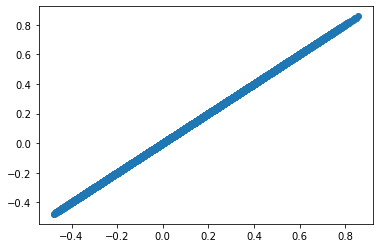

In [84]:
# Sanity check:
# Test assignment of subject map to group map
test_ind  = 1
roi_ind = 1
output_subfilename = surfacedir + subs.iloc[test_ind] + '_task-' + task + '_' + roi_names[roi_ind] + corr_type + '_'+hemi[0]+'h.npy'
test_sub = np.load(output_subfilename)
print(test_sub)

output_groupfilename = surfacedir + 'GroupMap_task-' + task + '_' + roi_names[roi_ind] + '_N' + str(sub_count) + '_' + corr_type + '_'+hemi[0]+'h.npy'
test_group = np.load(output_groupfilename)
test_group[test_ind]
plt.scatter(test_sub,test_group[test_ind])